<a href="https://colab.research.google.com/github/CheshireCat12/Deep_learning_challenges/blob/master/recap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.utils.data import DataLoader

from torch.optim.lr_scheduler import StepLR

In [36]:
# tensorboard

!pip install tensorboardcolab
from tensorboardcolab import *
tb = TensorBoardColab(graph_path="./logs")

Wait for 8 seconds...
TensorBoard link:
https://06781c51.ngrok.io


In [0]:
# General Settings

BATCH_SIZE = 128
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 30
LAYER_DIMS = [32, 16, 8]
lr_rate = 0.001

In [0]:
# Dataset Settings

TRAIN_SETTINGS = {
    "root": "./data",
    "train": True,
    "transform": transforms.ToTensor(),
    "download": True
}

TEST_SETTINGS = TRAIN_SETTINGS.copy()
TEST_SETTINGS["train"] = False

# Create Dataset

train_dataset = datasets.FashionMNIST(**TRAIN_SETTINGS)
test_dataset = datasets.FashionMNIST(**TEST_SETTINGS)

In [0]:
# Loader Settings

LOADER_SETTINGS = {
    "batch_size": BATCH_SIZE,
    "shuffle": True
}

# Create Loader

train_loader = DataLoader(train_dataset, **LOADER_SETTINGS)
val_loader = DataLoader(test_dataset, **LOADER_SETTINGS)

In [0]:
# Model Settings

# Create Encoder and Decoder that subclasses nn.Module
class Encoder(nn.Module):
    """Convnet Encoder"""

    def __init__(self):
        super(Encoder, self).__init__()
        # 28 x 28 -> 14 x 14
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=LAYER_DIMS[0], kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=LAYER_DIMS[0]),
            nn.Conv2d(in_channels=LAYER_DIMS[0], out_channels=LAYER_DIMS[0], kernel_size=(3, 3), padding=1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=LAYER_DIMS[0])
        )
        # 14 x 14 -> 7 x 7
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=LAYER_DIMS[0], out_channels=LAYER_DIMS[1], kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=LAYER_DIMS[1]),
            nn.Conv2d(in_channels=LAYER_DIMS[1], out_channels=LAYER_DIMS[1], kernel_size=(3, 3), padding=1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=LAYER_DIMS[1])
        )
        # 7 x 7 -> 4 x 4
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=LAYER_DIMS[1], out_channels=LAYER_DIMS[2], kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=LAYER_DIMS[2]),
            nn.Conv2d(in_channels=LAYER_DIMS[2], out_channels=LAYER_DIMS[2], kernel_size=(3, 3), padding=1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=LAYER_DIMS[2])
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out


In [0]:
class Decoder(nn.Module):
    """Convnet Decoder"""

    def __init__(self):
        super(Decoder, self).__init__()
        
        self.layers = nn.Sequential(
            # Formula: (H - 1)*stride - 2*padding + kernel_size
            
            # 4 x 4 -> 7 x 7
            nn.ConvTranspose2d(in_channels=LAYER_DIMS[2],
                               out_channels=LAYER_DIMS[2],
                               kernel_size=(3, 3),
                               padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=LAYER_DIMS[2]),
            nn.ConvTranspose2d(in_channels=LAYER_DIMS[2],
                               out_channels=LAYER_DIMS[1],
                               kernel_size=(3, 3),
                               stride=2,
                               padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=LAYER_DIMS[1]),
            
            # 7 x 7 -> 15 x 15
            nn.ConvTranspose2d(in_channels=LAYER_DIMS[1],
                               out_channels=LAYER_DIMS[1],
                               kernel_size=(3, 3),
                               padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=LAYER_DIMS[1]),
            nn.ConvTranspose2d(in_channels=LAYER_DIMS[1],
                               out_channels=LAYER_DIMS[0],
                               kernel_size=(5, 5),
                               stride=2,
                               padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=LAYER_DIMS[0]),
            
            # 15 x 15 -> 28 x 28
            nn.ConvTranspose2d(in_channels=LAYER_DIMS[0],
                               out_channels=LAYER_DIMS[0],
                               kernel_size=(3, 3),
                               padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=LAYER_DIMS[0]),
            nn.ConvTranspose2d(in_channels=LAYER_DIMS[0],
                               out_channels=1,
                               kernel_size=(2, 2),
                               stride=2,
                               padding=1),
            nn.ReLU()
        )


    def forward(self, x):
        out = self.layers(x)
        
        return out

In [0]:
encoder = Encoder()
decoder = Decoder()
encoder.to(DEVICE)
decoder.to(DEVICE)

parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr_rate)
loss_func = nn.MSELoss()

In [43]:
scheduler = StepLR(optimizer, 20, gamma=0.5)

# Train the CNN
encoder.train()
decoder.train()

for epoch in range(EPOCHS):
    
    losses = []
    scheduler.step()
    
    for images, _ in train_loader:
        images = images.to(DEVICE)
        
        output = encoder(images)
        output = decoder(output)

        # update the network
        optimizer.zero_grad()
        loss = loss_func(output, images)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    tb.save_value("Train Loss autoencoer", "train_loss_ae", epoch, np.mean(np.array(losses)))
        
    
    print(f'Epoch: {epoch+1}/{EPOCHS} | '
          f'Train_loss: {np.mean(np.array(losses)):.4f} | '
          f'lr: {scheduler.get_lr()}')
        

Epoch: 1/30 | Train_loss: 0.0347 | lr: [0.001]
Epoch: 2/30 | Train_loss: 0.0151 | lr: [0.001]
Epoch: 3/30 | Train_loss: 0.0124 | lr: [0.001]
Epoch: 4/30 | Train_loss: 0.0109 | lr: [0.001]
Epoch: 5/30 | Train_loss: 0.0099 | lr: [0.001]
Epoch: 6/30 | Train_loss: 0.0092 | lr: [0.001]
Epoch: 7/30 | Train_loss: 0.0087 | lr: [0.001]
Epoch: 8/30 | Train_loss: 0.0081 | lr: [0.001]
Epoch: 9/30 | Train_loss: 0.0077 | lr: [0.001]
Epoch: 10/30 | Train_loss: 0.0073 | lr: [0.001]
Epoch: 11/30 | Train_loss: 0.0069 | lr: [0.001]
Epoch: 12/30 | Train_loss: 0.0066 | lr: [0.001]
Epoch: 13/30 | Train_loss: 0.0064 | lr: [0.001]
Epoch: 14/30 | Train_loss: 0.0061 | lr: [0.001]
Epoch: 15/30 | Train_loss: 0.0058 | lr: [0.001]
Epoch: 16/30 | Train_loss: 0.0056 | lr: [0.001]
Epoch: 17/30 | Train_loss: 0.0054 | lr: [0.001]
Epoch: 18/30 | Train_loss: 0.0052 | lr: [0.001]
Epoch: 19/30 | Train_loss: 0.0051 | lr: [0.001]
Epoch: 20/30 | Train_loss: 0.0048 | lr: [0.00025]
Epoch: 21/30 | Train_loss: 0.0048 | lr: [0.0005

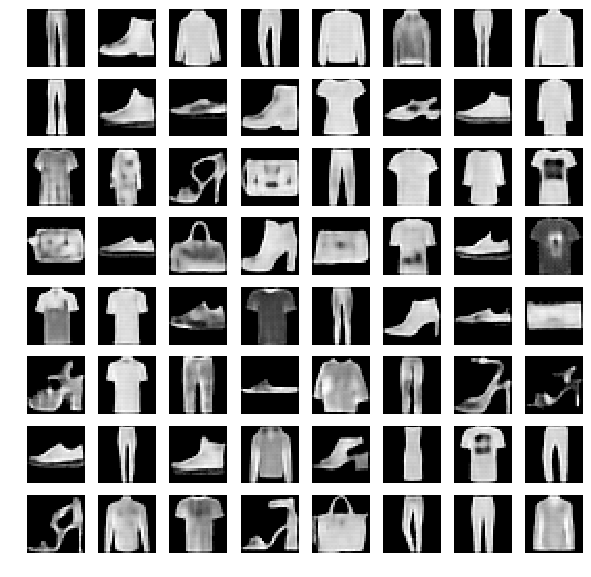

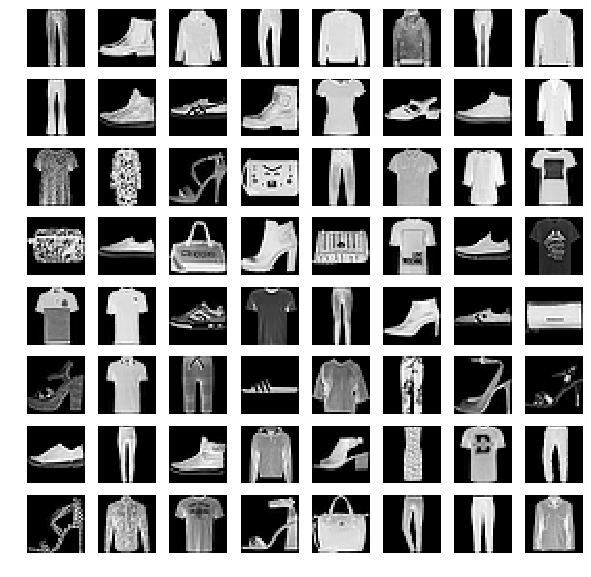

In [44]:
# Evaluation
encoder.eval()
decoder.eval()

test_imgs, _ = next(iter(val_loader))
test_imgs = test_imgs.to(DEVICE)

output = encoder(test_imgs)
output = decoder(output)

# Visualize in and output of the Autoencoder
fig_out = plt.figure('out', figsize=(10, 10))
fig_in = plt.figure('in', figsize=(10, 10))
for ind, (img_out, img_in) in enumerate(zip(output, test_imgs)):
    if ind > 63:
        break
    plt.figure('out')
    fig_out.add_subplot(8, 8, ind + 1)
    plt.imshow(img_out.data.cpu().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.figure('in')
    fig_in.add_subplot(8, 8, ind + 1)
    plt.imshow(img_in.data.cpu().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()